Step 0 : setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Setting the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Step 1 : Defining Autoencoder Models
+ Final decision to use CNN instead of MLP

In [2]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),  # Flatten a 28x28 image into a 784-dimensional vector
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim),  # Compression to latent_dim dimension
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()  # Ensure the output range is [0,1]
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon.view(-1, 1, 28, 28)  # Reconstructed back to 28x28 image format

In [3]:
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=32):
        super(ConvAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(32),  # Adding Batch Normalization
            nn.ReLU(),
            nn.Flatten(),  # Levelling up to one-dimensional
            nn.Linear(32 * 7 * 7, latent_dim)  # Compress to latent_dim
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),  # Restoration of spatial structure
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.Sigmoid()  # Ensure that the output value is between 0 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Step2 : Training Functions
+ Use L1 instead of MSE as the loss function

In [4]:
def train_autoencoder(model, train_loader, num_epochs=10):
    model.to(device)
    # criterion = nn.MSELoss() 
    criterion = nn.L1Loss() 
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        total_loss = 0
        for images, _ in train_loader:
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images) 

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")


Step3 : Calculation error
+ MSE
+ L1


In [5]:
def evaluate_autoencoder(model, data_loader):
    model.to(device)
    model.eval()
    
    mse_loss = nn.MSELoss()
    l1_loss = nn.L1Loss()
    
    total_mse, total_l1 = 0, 0
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            outputs = model(images)
            
            total_mse += mse_loss(outputs, images).item()
            total_l1 += l1_loss(outputs, images).item()
    
    avg_mse = total_mse / len(data_loader)
    avg_l1 = total_l1 / len(data_loader)
    
    return avg_mse, avg_l1

Step4 : Display reconstructed image (4x4 grid)
+ Original Images
+ Reconstructed Images

In [6]:
def show_reconstructed_images(model, data_loader, num_images=16):
    model.to(device)
    model.eval()
    
    images, _ = next(iter(data_loader))  # Get a batch of data
    images = images[:num_images].to(device)
    
    with torch.no_grad():
        outputs = model(images)

    # Convert to numpy format
    images = images.cpu().numpy().squeeze()
    outputs = outputs.cpu().numpy().squeeze()

    # Show original image
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i in range(4):
        for j in range(4):
            axes[i, j].imshow(images[i * 4 + j], cmap='gray')
            axes[i, j].axis('off')
    plt.suptitle("Original Images")
    plt.show()

    # Show reconstructed image
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i in range(4):
        for j in range(4):
            axes[i, j].imshow(outputs[i * 4 + j], cmap='gray')
            axes[i, j].axis('off')
    plt.suptitle("Reconstructed Images")
    plt.show()

Step5 : Downloading and loading MNIST datasets

In [7]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

Step6 : Training and evaluation of Autoencoder


Training Autoencoder with latent dimension = 64
Epoch [1/20], Loss: 0.1159
Epoch [2/20], Loss: 0.0340
Epoch [3/20], Loss: 0.0212
Epoch [4/20], Loss: 0.0189
Epoch [5/20], Loss: 0.0178
Epoch [6/20], Loss: 0.0170
Epoch [7/20], Loss: 0.0165
Epoch [8/20], Loss: 0.0161
Epoch [9/20], Loss: 0.0159
Epoch [10/20], Loss: 0.0156
Epoch [11/20], Loss: 0.0154
Epoch [12/20], Loss: 0.0151
Epoch [13/20], Loss: 0.0151
Epoch [14/20], Loss: 0.0149
Epoch [15/20], Loss: 0.0148
Epoch [16/20], Loss: 0.0146
Epoch [17/20], Loss: 0.0146
Epoch [18/20], Loss: 0.0144
Epoch [19/20], Loss: 0.0143
Epoch [20/20], Loss: 0.0142
Training MSE: 0.0027, L1 Loss: 0.0144
Testing  MSE: 0.0027, L1 Loss: 0.0144
Training Images Reconstruction:


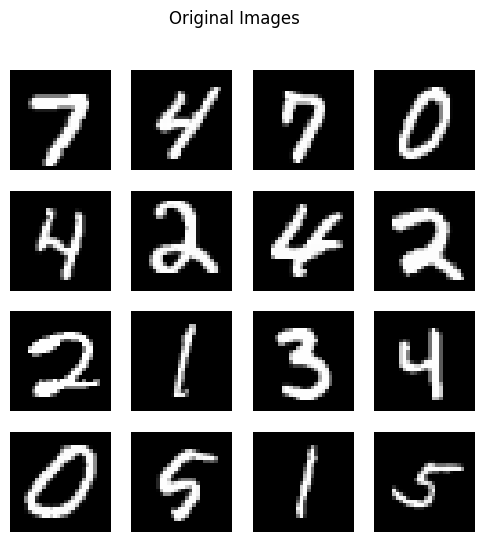

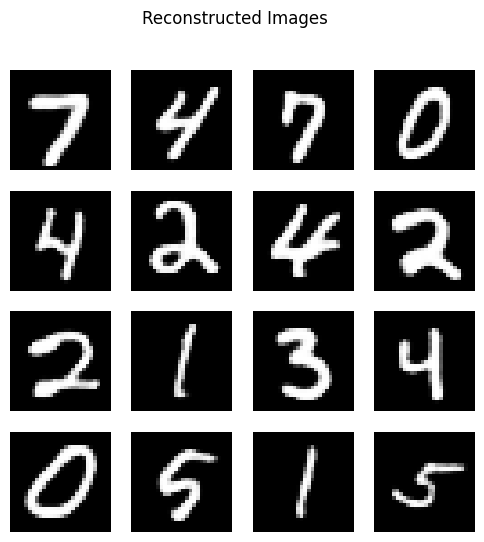

Testing Images Reconstruction:


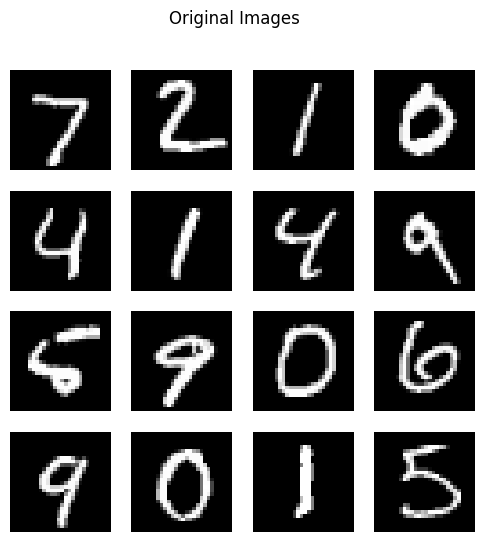

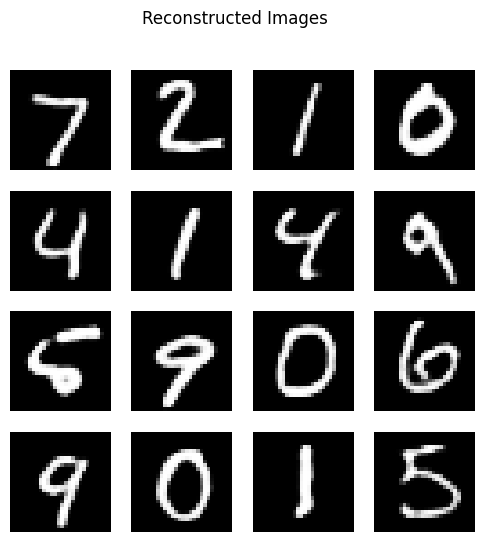


Training Autoencoder with latent dimension = 32
Epoch [1/20], Loss: 0.1227
Epoch [2/20], Loss: 0.0450
Epoch [3/20], Loss: 0.0292
Epoch [4/20], Loss: 0.0264
Epoch [5/20], Loss: 0.0251
Epoch [6/20], Loss: 0.0241
Epoch [7/20], Loss: 0.0234
Epoch [8/20], Loss: 0.0228
Epoch [9/20], Loss: 0.0224
Epoch [10/20], Loss: 0.0220
Epoch [11/20], Loss: 0.0217
Epoch [12/20], Loss: 0.0214
Epoch [13/20], Loss: 0.0211
Epoch [14/20], Loss: 0.0209
Epoch [15/20], Loss: 0.0208
Epoch [16/20], Loss: 0.0206
Epoch [17/20], Loss: 0.0205
Epoch [18/20], Loss: 0.0203
Epoch [19/20], Loss: 0.0201
Epoch [20/20], Loss: 0.0200
Training MSE: 0.0054, L1 Loss: 0.0201
Testing  MSE: 0.0054, L1 Loss: 0.0201
Training Images Reconstruction:


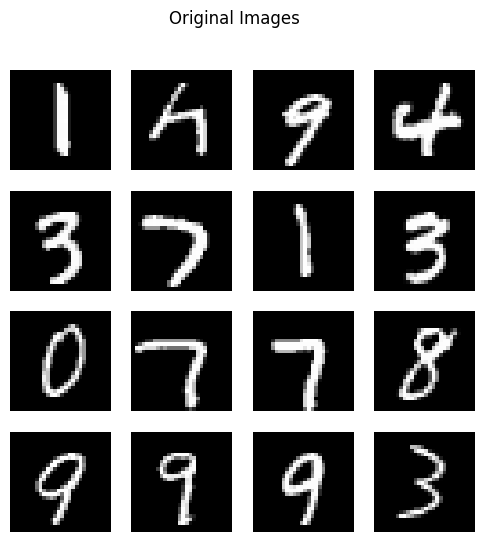

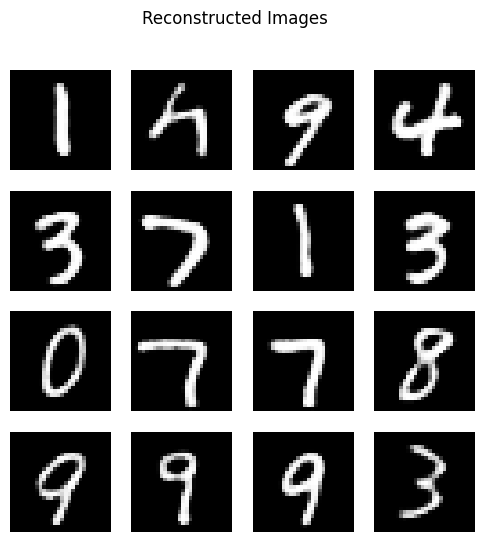

Testing Images Reconstruction:


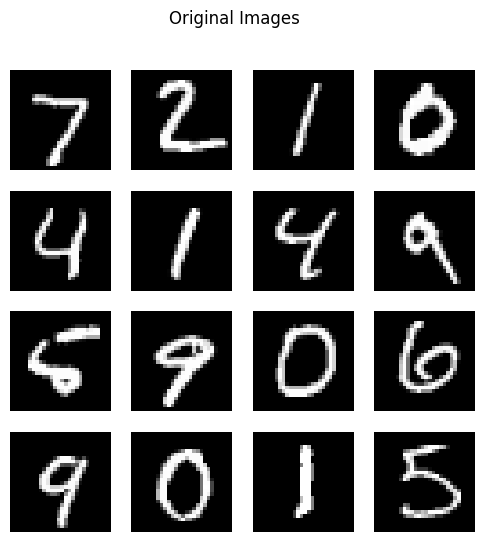

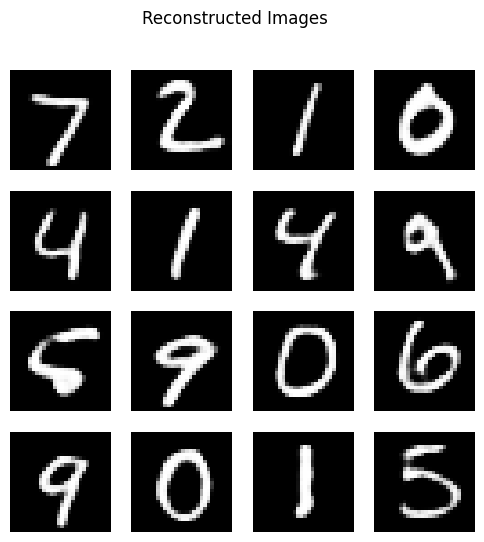


Training Autoencoder with latent dimension = 4
Epoch [1/20], Loss: 0.1395
Epoch [2/20], Loss: 0.1306
Epoch [3/20], Loss: 0.1303
Epoch [4/20], Loss: 0.1266
Epoch [5/20], Loss: 0.1244
Epoch [6/20], Loss: 0.1228
Epoch [7/20], Loss: 0.0961
Epoch [8/20], Loss: 0.0800
Epoch [9/20], Loss: 0.0762
Epoch [10/20], Loss: 0.0743
Epoch [11/20], Loss: 0.0731
Epoch [12/20], Loss: 0.0722
Epoch [13/20], Loss: 0.0715
Epoch [14/20], Loss: 0.0709
Epoch [15/20], Loss: 0.0704
Epoch [16/20], Loss: 0.0699
Epoch [17/20], Loss: 0.0694
Epoch [18/20], Loss: 0.0690
Epoch [19/20], Loss: 0.0687
Epoch [20/20], Loss: 0.0685
Training MSE: 0.0419, L1 Loss: 0.0682
Testing  MSE: 0.0421, L1 Loss: 0.0683
Training Images Reconstruction:


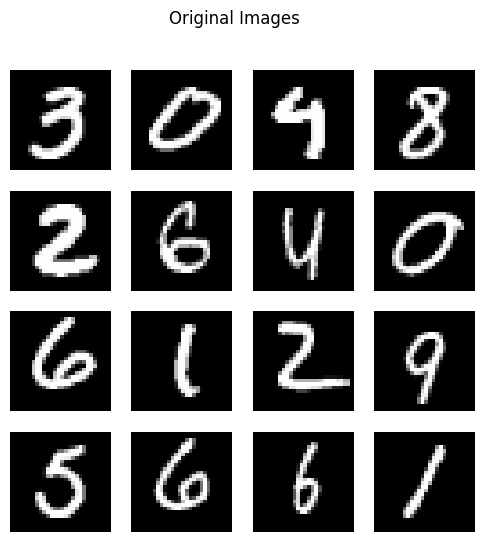

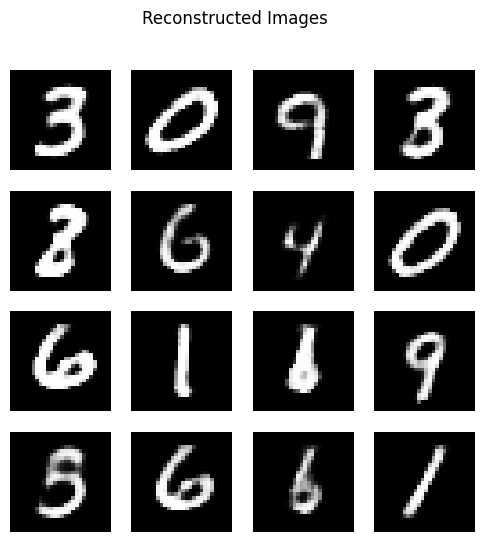

Testing Images Reconstruction:


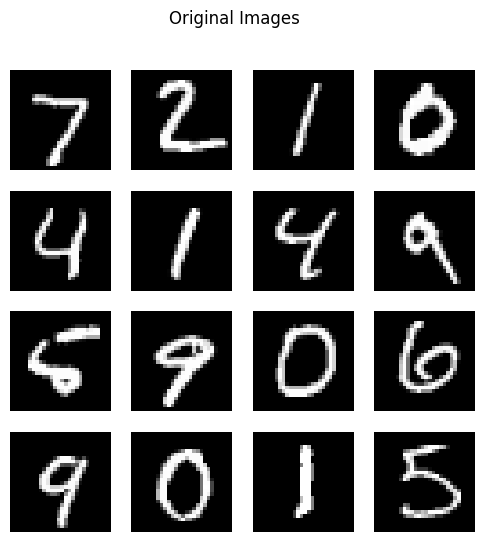

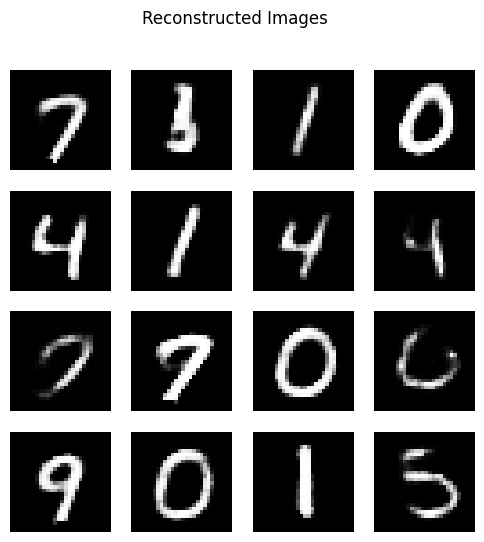

In [8]:
#  testing different latent_dim
latent_dims = [64, 32, 4]

for latent_dim in latent_dims:
    print(f"\nTraining Autoencoder with latent dimension = {latent_dim}")
    # autoencoder = Autoencoder(latent_dim)
    autoencoder = ConvAutoencoder(latent_dim)
    train_autoencoder(autoencoder, train_loader, num_epochs=20)

    train_mse, train_l1 = evaluate_autoencoder(autoencoder, train_loader)
    test_mse, test_l1 = evaluate_autoencoder(autoencoder, test_loader)

    print(f"Training MSE: {train_mse:.4f}, L1 Loss: {train_l1:.4f}")
    print(f"Testing  MSE: {test_mse:.4f}, L1 Loss: {test_l1:.4f}")

    # Show reconstructed image
    print("Training Images Reconstruction:")
    show_reconstructed_images(autoencoder, train_loader)

    print("Testing Images Reconstruction:")
    show_reconstructed_images(autoencoder, test_loader)

Step7 : Downloading and loading FashionMNIST datasets

In [9]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

Step8 : Training and evaluation of Autoencoder


Training Autoencoder with latent dimension = 64
Epoch [1/20], Loss: 0.0925
Epoch [2/20], Loss: 0.0546
Epoch [3/20], Loss: 0.0481
Epoch [4/20], Loss: 0.0449
Epoch [5/20], Loss: 0.0430
Epoch [6/20], Loss: 0.0414
Epoch [7/20], Loss: 0.0404
Epoch [8/20], Loss: 0.0396
Epoch [9/20], Loss: 0.0387
Epoch [10/20], Loss: 0.0380
Epoch [11/20], Loss: 0.0376
Epoch [12/20], Loss: 0.0370
Epoch [13/20], Loss: 0.0367
Epoch [14/20], Loss: 0.0363
Epoch [15/20], Loss: 0.0359
Epoch [16/20], Loss: 0.0358
Epoch [17/20], Loss: 0.0355
Epoch [18/20], Loss: 0.0353
Epoch [19/20], Loss: 0.0352
Epoch [20/20], Loss: 0.0350
Training MSE: 0.0060, L1 Loss: 0.0346
Testing  MSE: 0.0062, L1 Loss: 0.0355
Training Images Reconstruction:


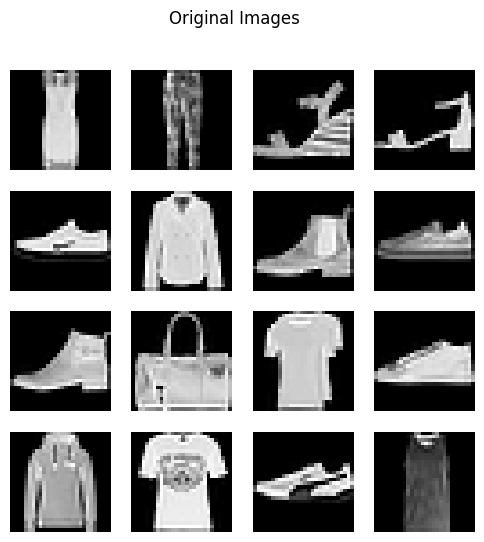

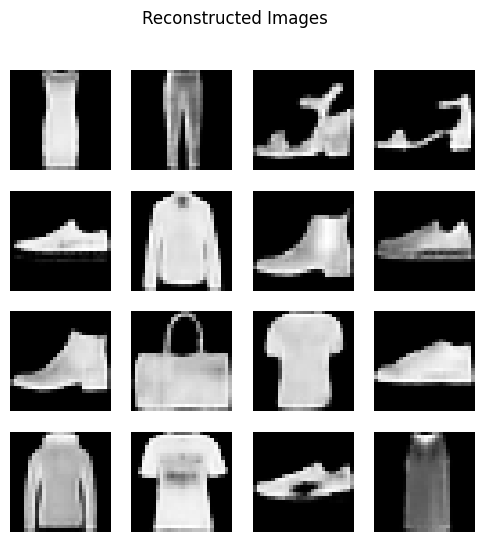

Testing Images Reconstruction:


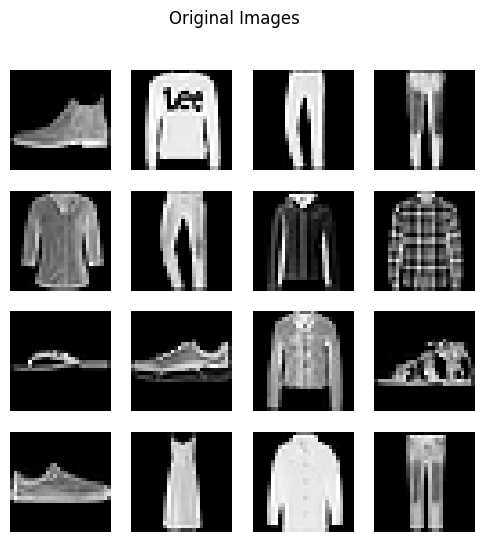

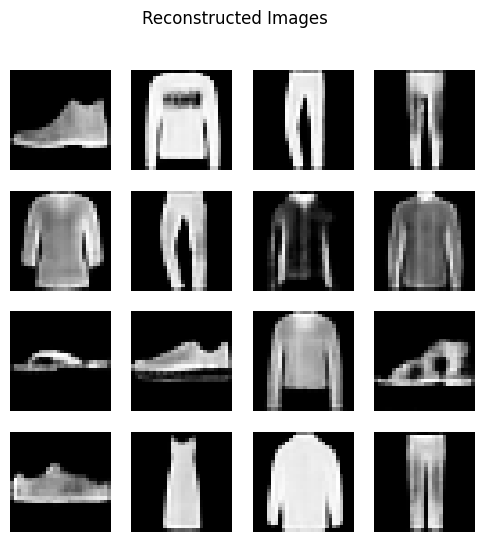


Training Autoencoder with latent dimension = 32
Epoch [1/20], Loss: 0.0961
Epoch [2/20], Loss: 0.0609
Epoch [3/20], Loss: 0.0548
Epoch [4/20], Loss: 0.0519
Epoch [5/20], Loss: 0.0496
Epoch [6/20], Loss: 0.0485
Epoch [7/20], Loss: 0.0474
Epoch [8/20], Loss: 0.0465
Epoch [9/20], Loss: 0.0457
Epoch [10/20], Loss: 0.0451
Epoch [11/20], Loss: 0.0446
Epoch [12/20], Loss: 0.0441
Epoch [13/20], Loss: 0.0437
Epoch [14/20], Loss: 0.0434
Epoch [15/20], Loss: 0.0431
Epoch [16/20], Loss: 0.0428
Epoch [17/20], Loss: 0.0425
Epoch [18/20], Loss: 0.0423
Epoch [19/20], Loss: 0.0421
Epoch [20/20], Loss: 0.0419
Training MSE: 0.0086, L1 Loss: 0.0419
Testing  MSE: 0.0089, L1 Loss: 0.0428
Training Images Reconstruction:


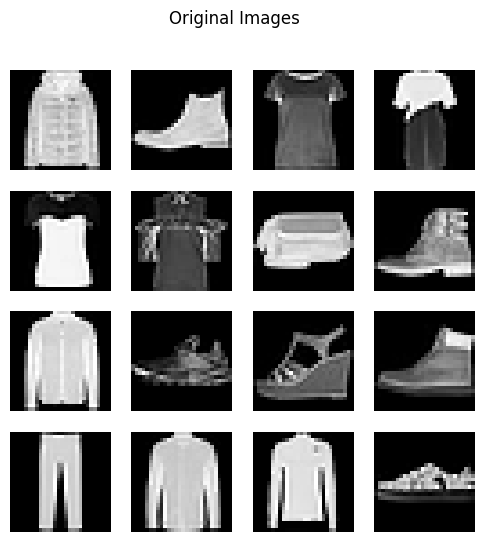

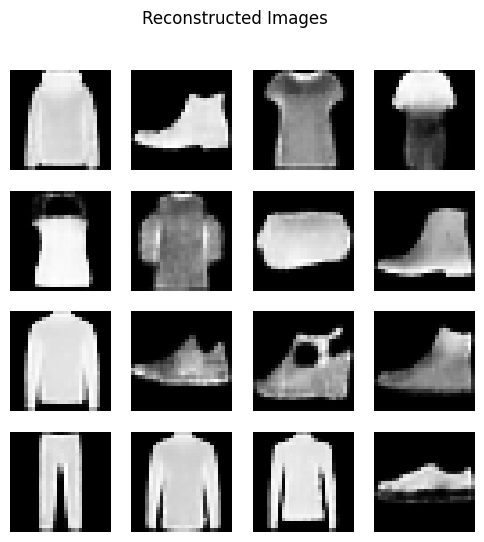

Testing Images Reconstruction:


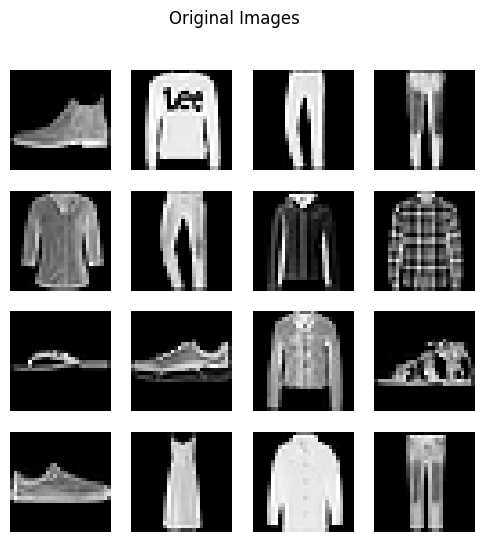

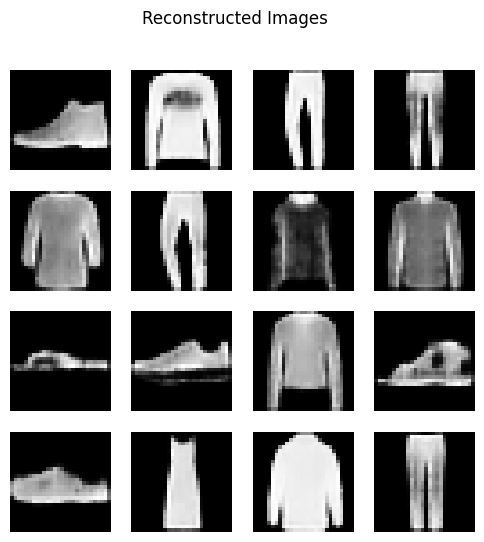


Training Autoencoder with latent dimension = 4
Epoch [1/20], Loss: 0.1373
Epoch [2/20], Loss: 0.0933
Epoch [3/20], Loss: 0.0863
Epoch [4/20], Loss: 0.0831
Epoch [5/20], Loss: 0.0811
Epoch [6/20], Loss: 0.0795
Epoch [7/20], Loss: 0.0781
Epoch [8/20], Loss: 0.0772
Epoch [9/20], Loss: 0.0764
Epoch [10/20], Loss: 0.0757
Epoch [11/20], Loss: 0.0752
Epoch [12/20], Loss: 0.0748
Epoch [13/20], Loss: 0.0741
Epoch [14/20], Loss: 0.0735
Epoch [15/20], Loss: 0.0732
Epoch [16/20], Loss: 0.0729
Epoch [17/20], Loss: 0.0726
Epoch [18/20], Loss: 0.0725
Epoch [19/20], Loss: 0.0721
Epoch [20/20], Loss: 0.0720
Training MSE: 0.0237, L1 Loss: 0.0714
Testing  MSE: 0.0240, L1 Loss: 0.0724
Training Images Reconstruction:


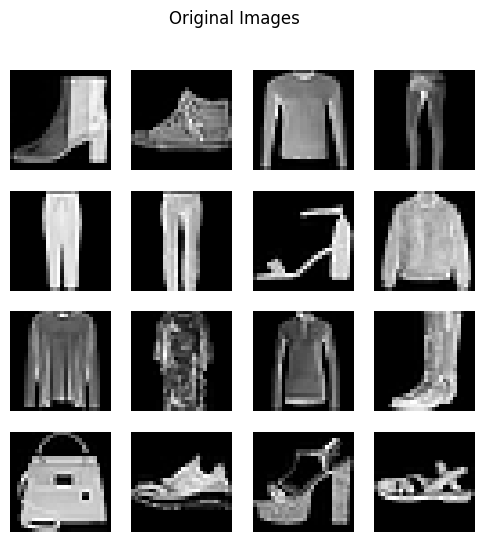

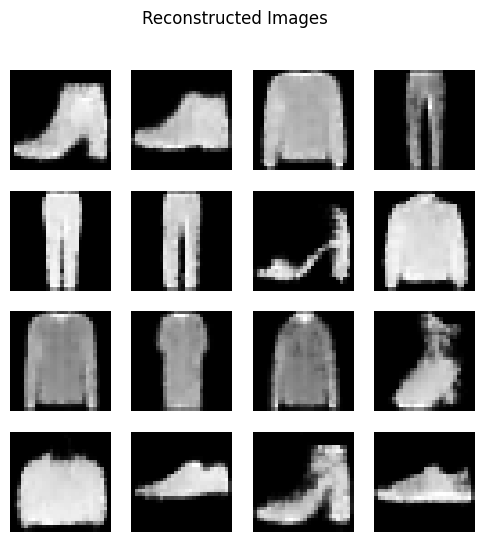

Testing Images Reconstruction:


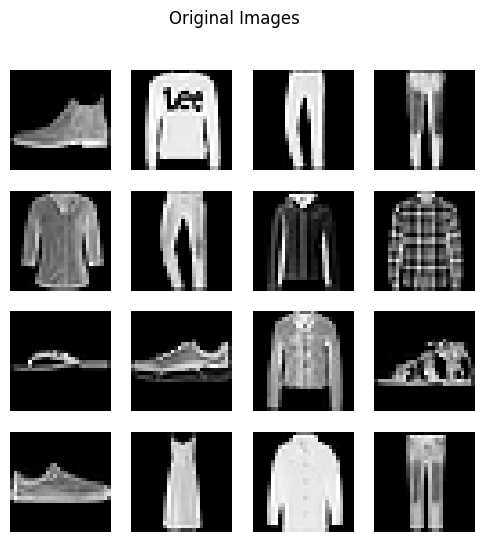

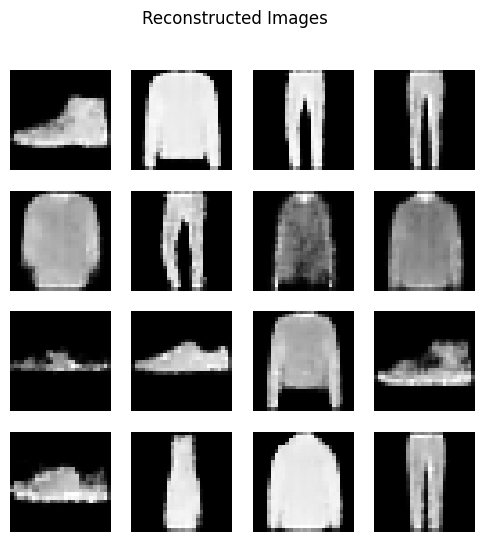

In [10]:
#  testing different latent_dim
latent_dims = [64, 32, 4]

for latent_dim in latent_dims:
    print(f"\nTraining Autoencoder with latent dimension = {latent_dim}")
    # autoencoder = Autoencoder(latent_dim)
    autoencoder = ConvAutoencoder(latent_dim)
    train_autoencoder(autoencoder, train_loader, num_epochs=20)

    train_mse, train_l1 = evaluate_autoencoder(autoencoder, train_loader)
    test_mse, test_l1 = evaluate_autoencoder(autoencoder, test_loader)

    print(f"Training MSE: {train_mse:.4f}, L1 Loss: {train_l1:.4f}")
    print(f"Testing  MSE: {test_mse:.4f}, L1 Loss: {test_l1:.4f}")

    # Show reconstructed image
    print("Training Images Reconstruction:")
    show_reconstructed_images(autoencoder, train_loader)

    print("Testing Images Reconstruction:")
    show_reconstructed_images(autoencoder, test_loader)